In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from pyndamics import *

pyndamics version  0.0.11


In [4]:
import pandas as pd

In [5]:
data=pd.read_csv('data/temperature.txt',delim_whitespace=True)
data

,Year,Annual_Mean,5-year_Mean
0,1882,-0.08,-0.16
1,1883,-0.19,-0.19
2,1884,-0.26,-0.22
3,1885,-0.30,-0.27
4,1886,-0.29,-0.27
...,...,...,...
129,2011,0.60,0.65
130,2012,0.63,0.67
131,2013,0.65,0.70
132,2014,0.74,*


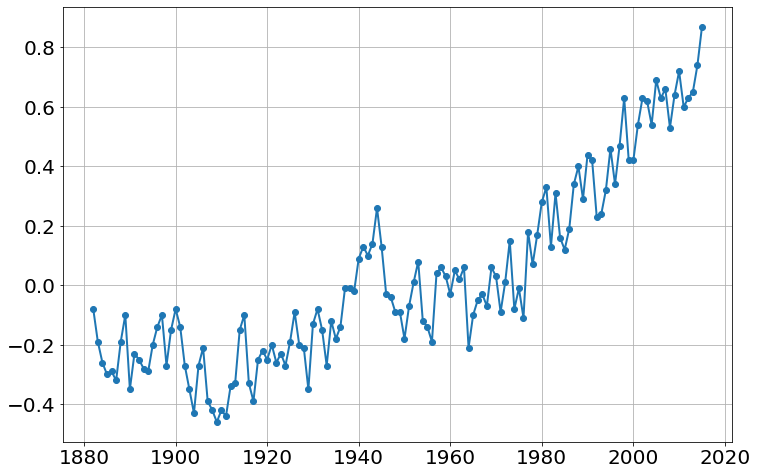

In [6]:
t=array(data['Year'])
T=array(data['Annual_Mean'])
plot(t,T,'-o')

* Equation 4 in IV 3 Climate Influence of Solar Variability
* https://web.bryant.edu/~bblais/pdf/energy_balance.pdf

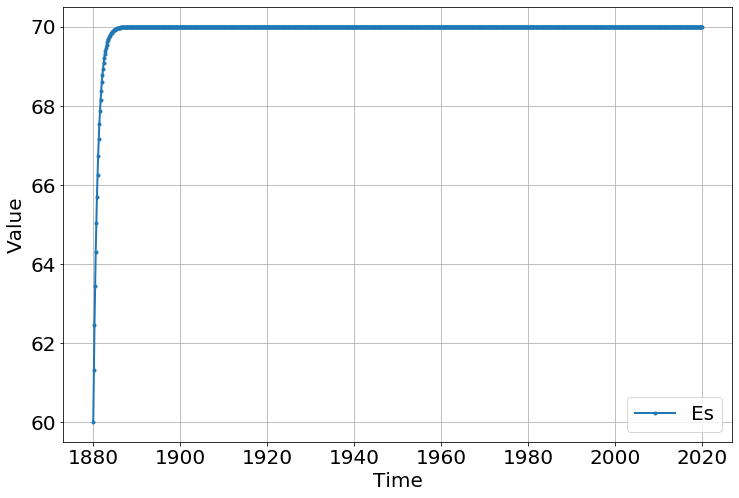

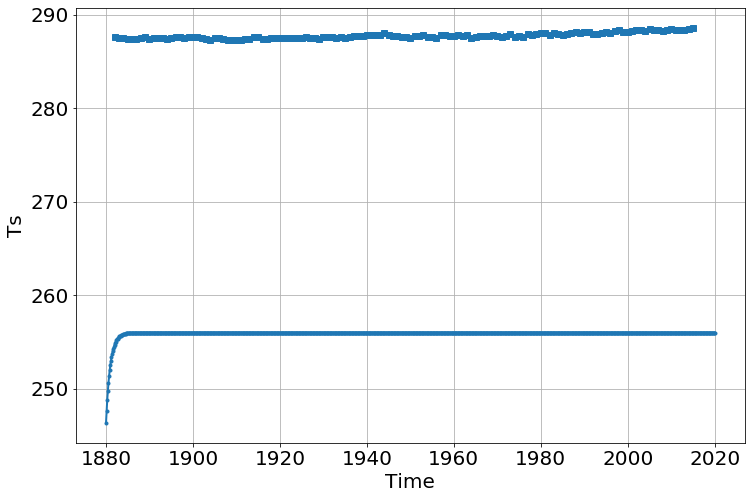

<Figure size 864x576 with 0 Axes>

In [9]:
sim=Simulation()
sim.add("Es'=C*(100-albedo*100-Es)",60,plot=True)
sim.add("Ts=88.5*Es**0.25",plot=True)
sim.params(C=1,albedo=0.3)
sim.add_data(t=t,Ts=T+14.6+273.13,plot=True)  # adjust temperature to average temp (C) to kelvin
sim.run(1880,2020)


Above is the no-atmosphere case.  The simplest atmosphere to add is an atmosphere which absorbs $\gamma$ amount of the outgoing energy from the surface of the Earth.

\begin{eqnarray}
dE_{\rm surface}/dt &=& +S/4-S/4*a + E_{\rm atm} \\
dE_{\rm atm}/dt &=& +\gamma E_{\rm surface} - 2\cdot E_{\rm atm}
\end{eqnarray}

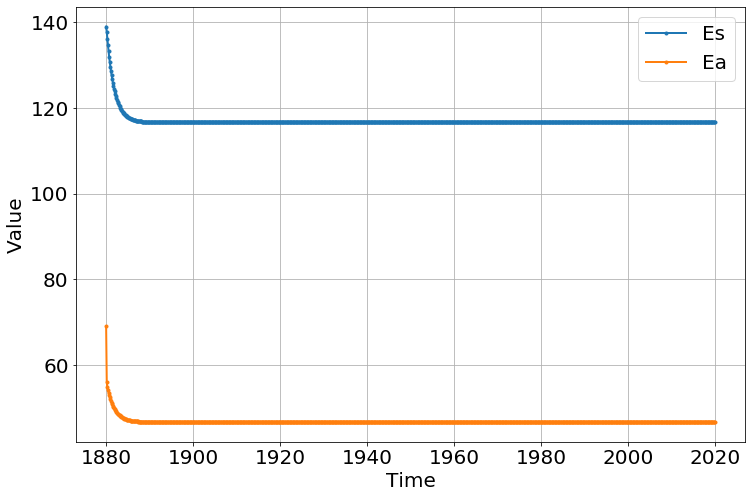

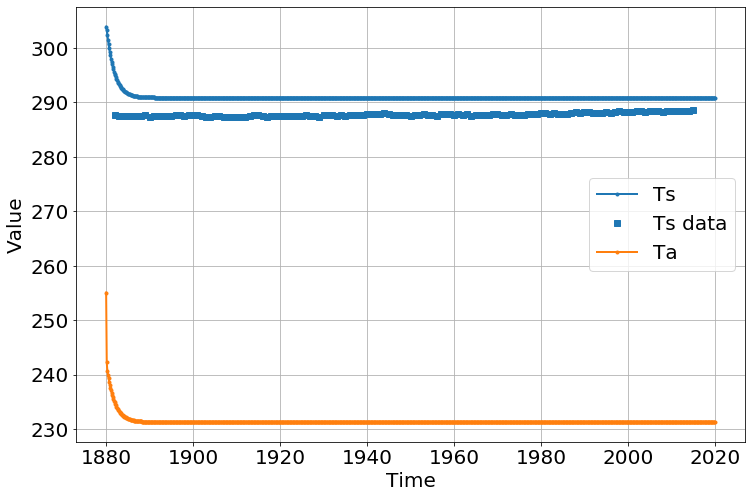

<Figure size 864x576 with 0 Axes>

In [11]:
sim=Simulation()
sim.add("Es'=C1*(100-albedo*100+Ea-Es)",139,plot=1)
sim.add("Ea'=C2*(γ*Es-Ea-Ea)",69,plot=1)
sim.add("Ts=88.5*Es**0.25",plot=2)
sim.add("Ta=88.5*Ea**0.25",plot=2)
sim.params(C1=1,C2=10,albedo=0.3,γ=.8)
sim.add_data(t=t,Ts=T+14.6+273.13,plot=2)
sim.run(1880,2020)

In [12]:
from pyndamics.emcee import *

In [13]:
model=MCMCModel(sim,
               γ=Uniform(0,1),
               initial_Es=Uniform(100,140))

Sampling Prior...
Done.
0.51 s
Running MCMC 1/2...
Done.
2 m, 7.80 s
Running MCMC 2/2...
Done.
2 m, 12.38 s


<Figure size 864x576 with 0 Axes>

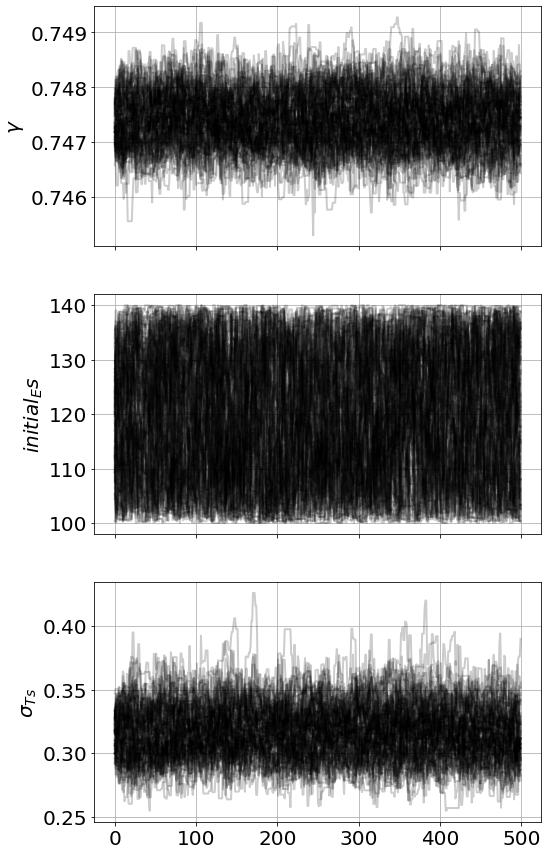

In [14]:
model.run_mcmc(500,repeat=2)
model.plot_chains()

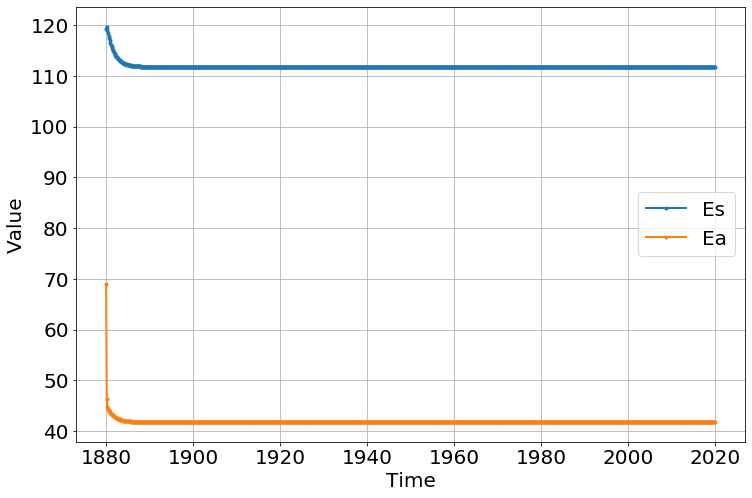

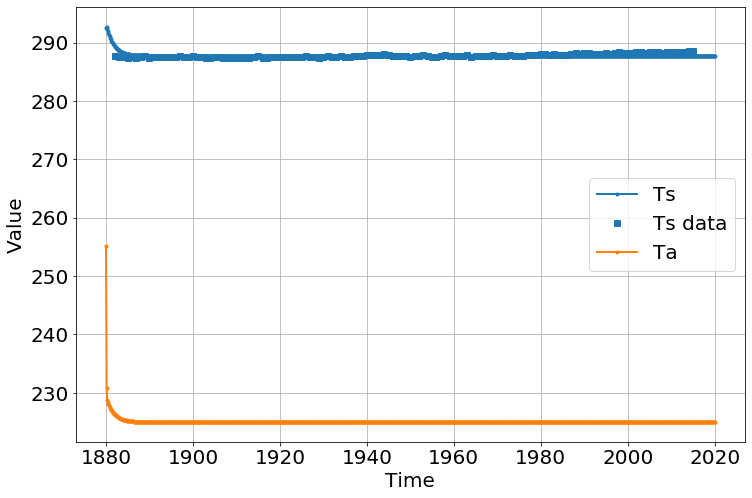

<Figure size 864x576 with 0 Axes>

In [15]:
sim.run(1880,2020)

Data from: https://nsidc.org/data/seaice_index/archives

In [55]:
icedata=pd.read_csv('data/N_seaice_extent_daily_v3.0.csv')

In [49]:
icedata.columns

Index(['Year', ' Month', ' Day', '     Extent', '    Missing', ' Source Data'], dtype='object')

In [65]:
ice_extent=array([float(_) for _ in icedata[1:]['     Extent']])
y=array([int(_) for _ in icedata[1:]['Year']])
m=array([int(_) for _ in icedata[1:][' Month']])
d=array([int(_) for _ in icedata[1:][' Day']])

In [59]:
def date_to_float(d):
    
    from dateutil import parser
    import datetime  
    from numpy import array
    
    try:
        dt=parser.parse(d)
        year=dt.year
        f=year+(dt-datetime.datetime(year, 1, 1, 0, 0))/(datetime.datetime(year+1, 1, 1, 0, 0)-datetime.datetime(year, 1, 1, 0, 0))

        return f
    except TypeError:
        f=[date_to_float(_) for _ in array(d)]
        return array(f)


In [60]:
t=[]
for dd,mm,yy in zip(d,m,y):
    t.append(date_to_float('%d/%d/%d' % (dd,mm,yy)))

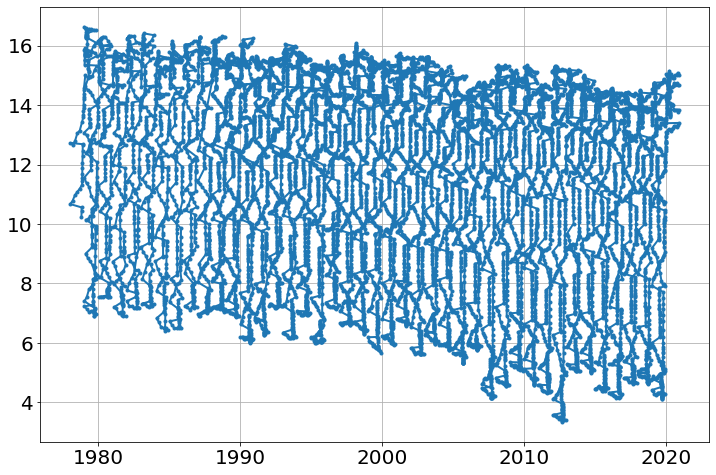

In [72]:
plot(t,ice_extent,'.-')

In [67]:
T_time=array(data['Year'])
T_value=array(data['Annual_Mean'])

In [68]:
T_value=T_value[T_time>=1978]
T_time=T_time[T_time>=1978]

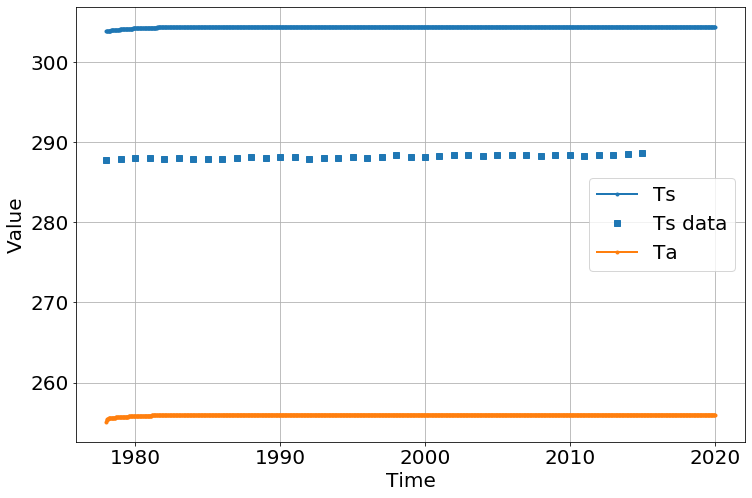

<Figure size 864x576 with 0 Axes>

In [71]:
sim=Simulation()
sim.add("Es'=C1*(100-albedo*100+Ea-Es)",139)
sim.add("Ea'=C2*(γ*Es-Ea-Ea)",69)
sim.add("Ts=88.5*Es**0.25",plot=1)
sim.add("Ta=88.5*Ea**0.25",plot=1)
sim.params(C1=1,C2=10,albedo=0.3,γ=1.0)
sim.add_data(t=T_time,Ts=T_value+14.6+273.13,plot=1)
sim.run(1978,2020)

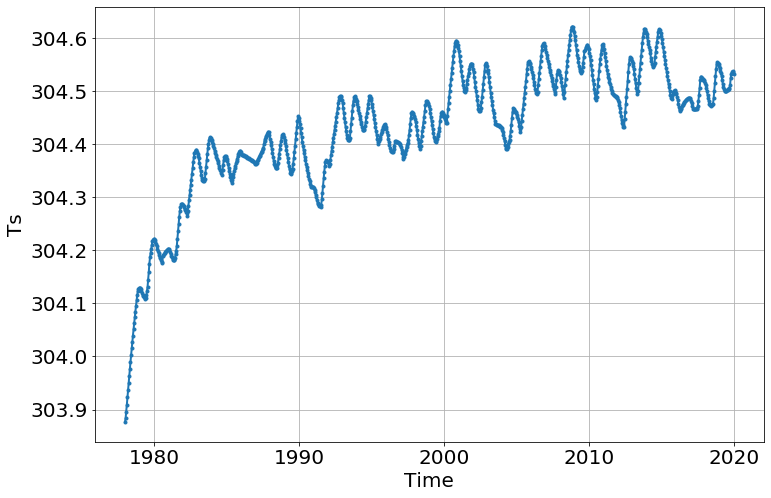

<Figure size 864x576 with 0 Axes>

In [75]:
sim=Simulation()
sim.add("albedo=0.3+0.001*(ice_extent(t)-12)")
sim.add("Es'=C1*(100-albedo*100+Ea-Es)",139)
sim.add("Ea'=C2*(γ*Es-Ea-Ea)",69)
sim.add("Ts=88.5*Es**0.25",plot=1)
sim.add("Ta=88.5*Ea**0.25",plot=False)
sim.params(C1=1,C2=10,γ=1.0)
sim.add_data(t=T_time,Ts=T_value+14.6+273.13,plot=False)
sim.add_interp_function(t=t,ice_extent=ice_extent)
sim.run(1978,2020)